In [1]:
%load_ext autoreload
%autoreload 2

# Round Robin Experiment
Showcase how AutoQuorum detects and reacts to changing workload.

**Workload:** Each server (starting with LA) gets 90% of the load. The rest of the requests are split evenly among the remaining 4 servers. All requests are writes.

**Conclusions:** AutoQuorum accurately identifies changes in workload and switches leader to the server with 90% load. Static LA leader and ETCD are equivalent.

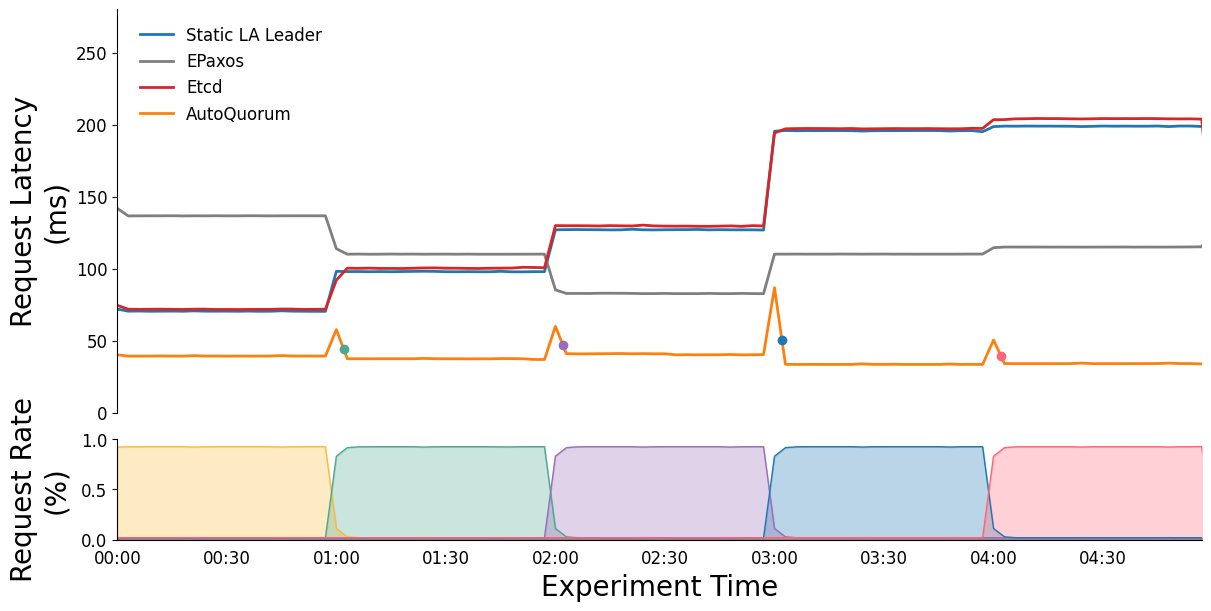

In [9]:
from graphs.round_robin import graph_round_robin
graph_round_robin()

In [10]:
from graphs.round_robin import round_robin_data
aq_data = round_robin_data("AutoQuorum")
print("AutoQuorum RECONFIGURATIONS:")
aq_data.show_reconfigurations()
baseline_data = round_robin_data("Baseline")
print("Baseline (Static LA leader) STRATEGY:")
baseline_data.show_initial_cluster_strategy()

AutoQuorum RECONFIGURATIONS:


,curr_strat_latency,opt_strat_latency,curr_strat,opt_strat
timestamp,,,,
2025-03-10 18:11:35.254,66.395595,37.588427,"{'leader': 1, 'read_quorum_size': 4, 'write_quorum_size': 2, 'read_strategies': ['ReadAsWrite', 'ReadAsWrite', 'ReadAsWrite', 'ReadAsWrite', 'ReadAsWrite']}","{'leader': 2, 'read_quorum_size': 4, 'write_quorum_size': 2, 'read_strategies': ['ReadAsWrite', 'ReadAsWrite', 'ReadAsWrite', 'BallotRead', 'BallotRead']}"
2025-03-10 18:12:35.271,66.247555,40.030610,"{'leader': 2, 'read_quorum_size': 4, 'write_quorum_size': 2, 'read_strategies': ['ReadAsWrite', 'ReadAsWrite', 'ReadAsWrite', 'BallotRead', 'BallotRead']}","{'leader': 3, 'read_quorum_size': 4, 'write_quorum_size': 2, 'read_strategies': ['ReadAsWrite', 'ReadAsWrite', 'ReadAsWrite', 'BallotRead', 'BallotRead']}"
2025-03-10 18:13:35.286,109.009963,34.146957,"{'leader': 3, 'read_quorum_size': 4, 'write_quorum_size': 2, 'read_strategies': ['ReadAsWrite', 'ReadAsWrite', 'ReadAsWrite', 'BallotRead', 'BallotRead']}","{'leader': 4, 'read_quorum_size': 4, 'write_quorum_size': 2, 'read_strategies': ['BallotRead', 'BallotRead', 'BallotRead', 'ReadAsWrite', 'ReadAsWrite']}"
2025-03-10 18:14:35.324,56.346955,34.077485,"{'leader': 4, 'read_quorum_size': 4, 'write_quorum_size': 2, 'read_strategies': ['BallotRead', 'BallotRead', 'BallotRead', 'ReadAsWrite', 'ReadAsWrite']}","{'leader': 5, 'read_quorum_size': 4, 'write_quorum_size': 2, 'read_strategies': ['BallotRead', 'BallotRead', 'BallotRead', 'ReadAsWrite', 'ReadAsWrite']}"


Baseline (Static LA leader) STRATEGY:


{'nodes': [1, 2, 3, 4, 5],
 'initial_leader': 1,
 'initial_flexible_quorum': {'read_quorum_size': 3, 'write_quorum_size': 3},
 'optimize': False,
 'optimize_threshold': None,
 'initial_read_strat': None}

# Read Strats Experiments
Shows the advantage of DQR over QuorumRead (handles concurrent writes better).

**Workload:** 90% of the load is split evenly among the 3 US nodes and 10% evenly among the 2 EU nodes. 90% of requests are reads. 

## Overview bar chart
Even though 90% of requests are reads, a read-optimized cluster using QuorumReads is still outcompeted by a write-optimized cluster using RAW. This is because there are enough concurrent writes in the system to slow the QuorumReads down. (300 request/sec at each server => 30 writes/sec at each server => about 90% of reads are slowed by concurrent writes as seen in varied workload graph)

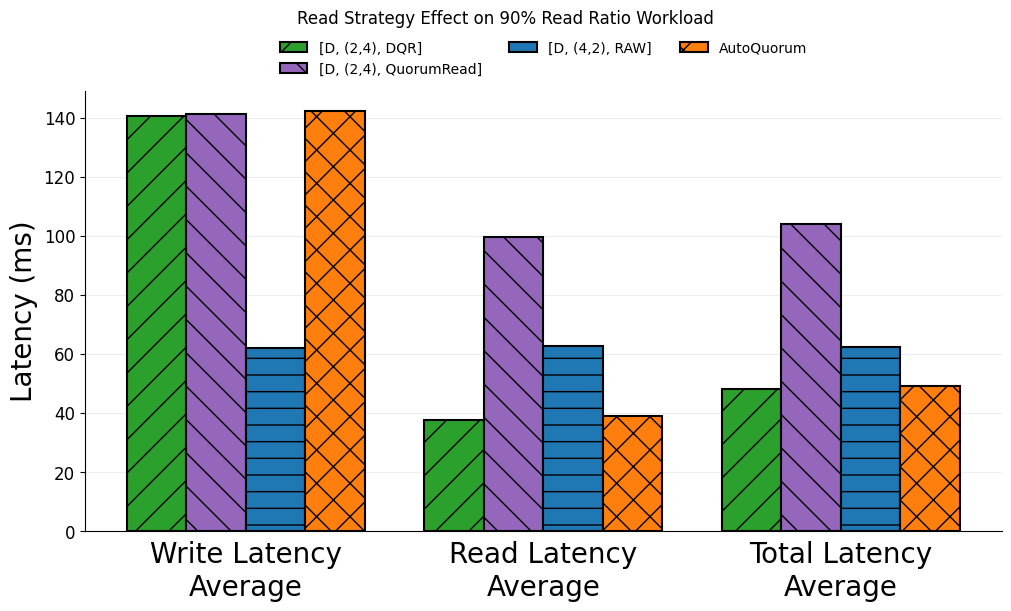

In [9]:
from graphs.read_strats import overview_bar_chart
overview_bar_chart()

## Breakdown bar chart
Here we can see the reason DQR fairs better is that the nodes near the leader (Dallas) have the leader in their nearest read quorum. Therefore they end their reads after communicating with a read quorum even in the presence of concurrent writes. The nodes in EU often have to wait for a concurrent write to get commited or get a response from Dallas, whichever happens first. In this case a concurrent write shouldn't take any longer than the time it takes to contact Dallas and so we see the algorithm devolve to QuorumRead for these nodes. Timing differences between when the read and the limiting concurrent write started accounts for the deviation of QuorumRead nodes.

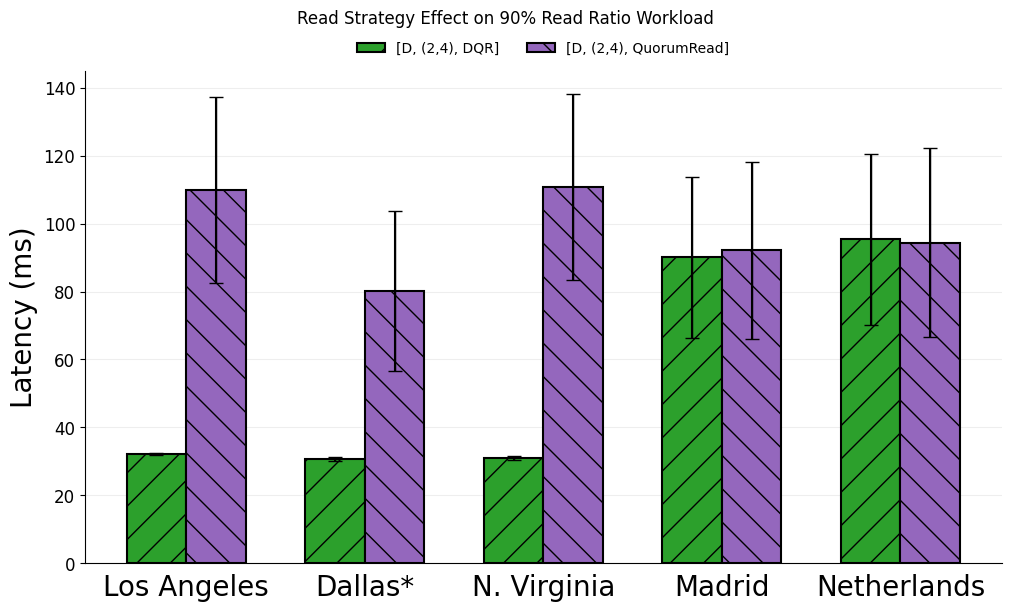

In [13]:
from graphs.read_strats import breakdown_bar_chart
breakdown_bar_chart()

## Varied workloads
Here we examine the behavior of read strategies when different characteristics of the workload are varied. The original workload corresponds to the right-most point of each chart.
 - **Read Ratio:** AutoQuorum chooses the write-optimized strategy until the read ratio is high enough to justify the read-optimized DQR strategy. QuorumRead is unable to take advantage of a read-optimized strategy because of concurrent writes.
 - **Concurrent Write Rate:** As the concurrent write rate increases, QuorumRead quickly becomes worse that the write-optimized strategy, despite 90% reads. DQR, being more resistant to concurrent writes, outcompetes the write-optimized strategy. AutoQuorum always finds the optimal strategy, DQR.
 - **Relative US load:** As the load tends to an even distribution, DQR's improvement over RAW increases as the load tends to an even distribution. This is because the workload becomes less concentrated near the leader making a write-optimized strategy weaker.

/home/kevin/rise/auto-quorum/benchmarks/graphs/read_strats.py:107: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))


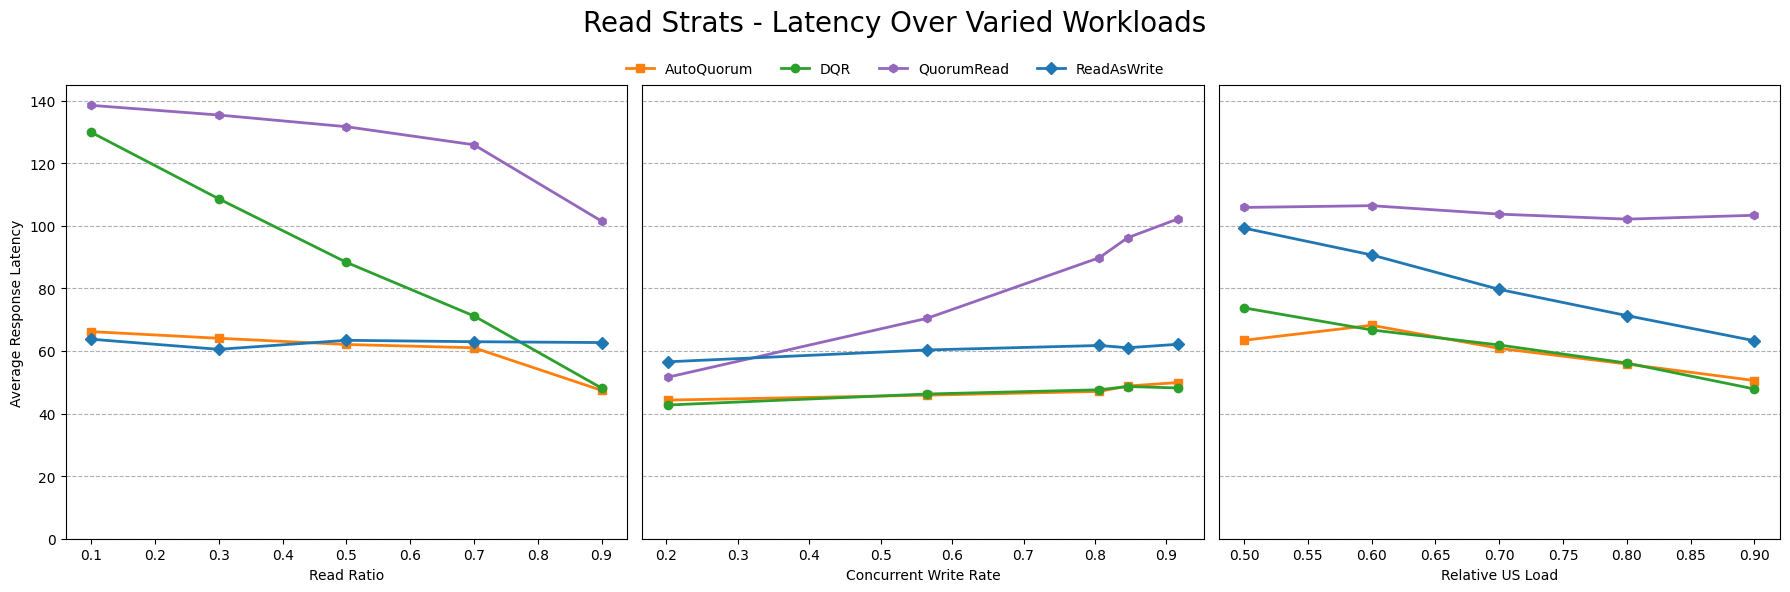

In [26]:
from graphs.read_strats import graph_read_strats_over_workloads
graph_read_strats_over_workloads()

For Relative US Load = 0.5 AutoQuorum discovers that its best to move the leader to the most central position in the cluster (N Virginia) since the load is completely evenly distibuted.

In [15]:
from graphs.read_strats import read_strats_data
exp_data = read_strats_data("us-load-0.5/AutoQuorum")
exp_data.show_reconfigurations()

,curr_strat_latency,opt_strat_latency,curr_strat,opt_strat
timestamp,,,,
2025-03-13 10:08:48.714,84.040055,70.476628,"{'leader': 2, 'read_quorum_size': 2, 'write_quorum_size': 4, 'read_strategies': ['BallotRead', 'BallotRead', 'BallotRead', 'BallotRead', 'BallotRead']}","{'leader': 3, 'read_quorum_size': 2, 'write_quorum_size': 4, 'read_strategies': ['BallotRead', 'BallotRead', 'BallotRead', 'BallotRead', 'BallotRead']}"


# Mixed Strats Experiments
Showcases the extra gains that can be had by considering heterogonous read strategies.

**Workload:** A split workload where 50% of the load is at the far left node LA and 45% of the load is in Europe. A write-heavy workload with 50% reads.

## Overview bar chart
AutoQuorum is able to improve read latency by about 20% by using a mix of DQR and RAW reads (still keeps write-optimized quorums).

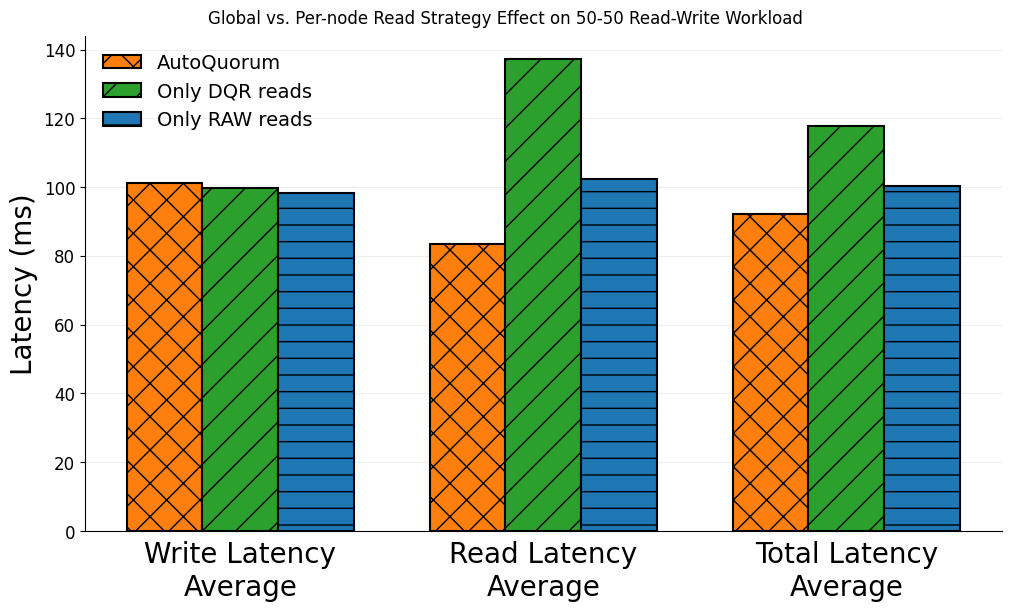

In [19]:
from graphs.mixed_strats import overview_bar_chart
overview_bar_chart()

## Breakdown bar chart
Since the workload is write-heavy and the majority of the load is at LA, it makes sense to use a write-optimized strategy with LA as the leader. As nodes get farther away from the leader they pay increasingly costly forwarding costs. This can't be avoided for writes but for reads read quorums with DQR out compete RAW reads once forwarding costs get too high. AutoQuorum optimizes read strategy on per-node basis and therefore chooses the best strategy for each node. 

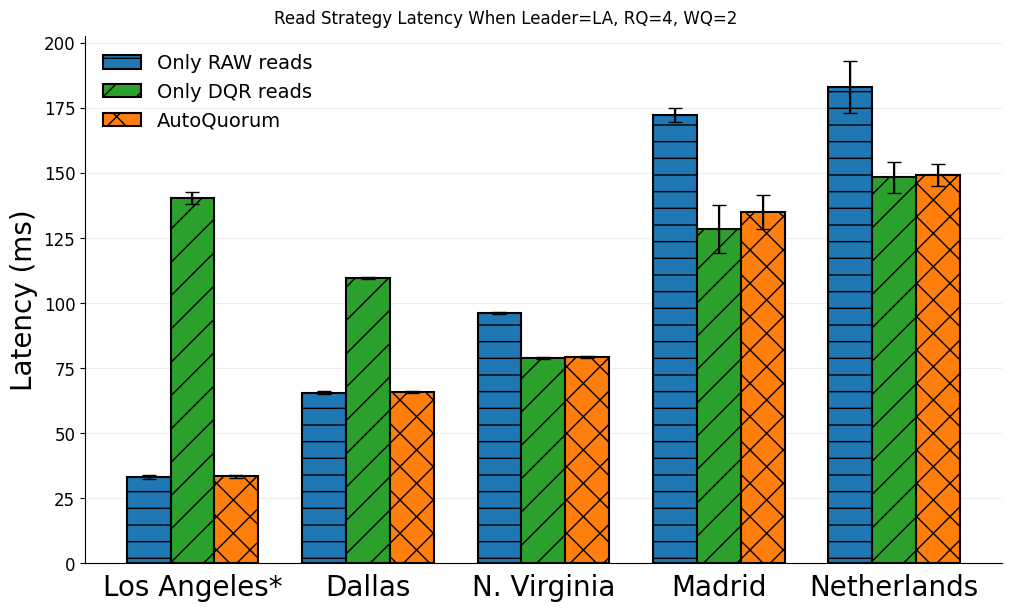

In [17]:
from graphs.mixed_strats import breakdown_bar_chart
breakdown_bar_chart()

## Varied workloads

/home/kevin/rise/auto-quorum/benchmarks/graphs/mixed_strats.py:107: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))


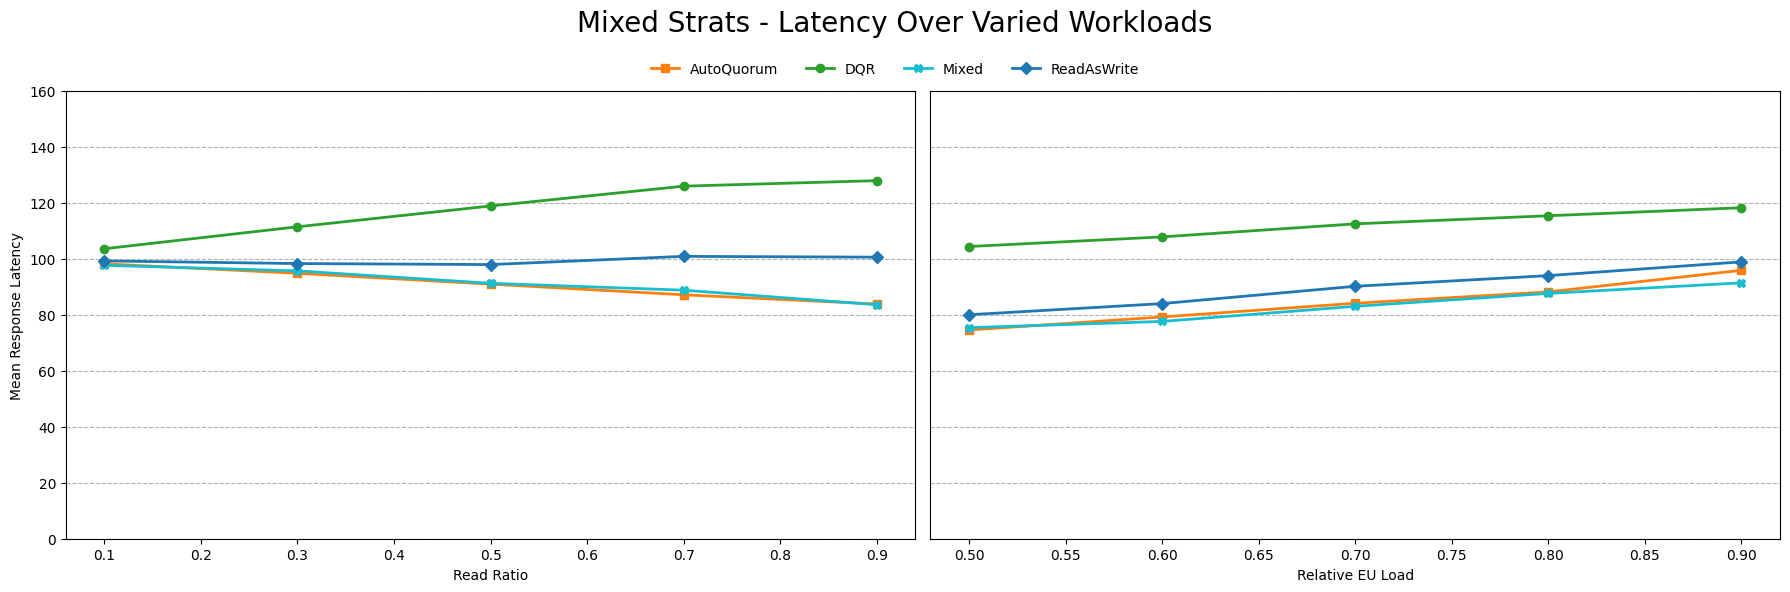

In [29]:
from graphs.mixed_strats import graph_mixed_strats_over_workload
graph_mixed_strats_over_workload()

# Shifting Conditions Experiments - WIP

/home/kevin/rise/auto-quorum/benchmarks/graphs/shifting_conditions.py:100: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  requests = pd.concat(exp_data.client_data.values())
/home/kevin/rise/auto-quorum/benchmarks/graphs/shifting_conditions.py:100: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  requests = pd.concat(exp_data.client_data.values())
/home/kevin/rise/auto-quorum/benchmarks/graphs/shifting_conditions.py:100: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA ent

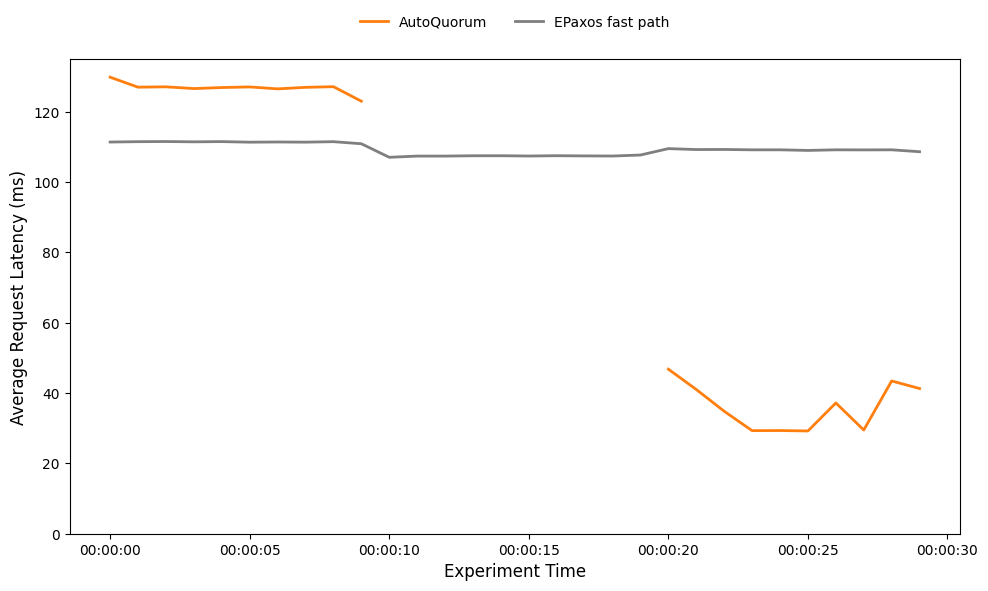

In [11]:
from graphs.shifting_conditions import graph_shifting_conditions
graph_shifting_conditions()

# Even Load Experiments TODO: why are Etcd reads slow?
Compare AutoQuorum to other protocols. Give other protocols the favorable conditions (EPaxos evenly distributed load, Etcd static leader well positioned)

**Workload:** Evenly distributed load with varying read ratios.

**Conclusions:**
 - **Read ratio 0.0:** AutoQuorum uses the write-optimized strat \[NV, (4,2), RAW\] and is able to outcompete the other protocols. EPaxos doesn't have to pay leader forwarding costs which is maximally powerful in and evenly distributed load setting. But the super quorum of EPaxos outweigh this benefit when compared against AutoQuorum's optimized write quorums. Etcd pays forwarding costs but is worse because is doesn't utilize flexible quorums.
 - **Read ratio 0.5:** AutoQuorum finds a balanced strat \[D, (3,3) Mixed\]. It forgoes the most central placement of a leader at NV (which is expected to be the best due to even load distribution) in favor of the central US node Dallas. This increases forwarding costs in Europe but this is outweighed by faster US nodes and EU nodes' use of DQR. 
 - **Read ratio 0.95 and 1.0:** AutoQuorum commits to a fully read-optimized strat \[D, (2,4), DQR\] and is able to drive latency down even more with local read quorums.

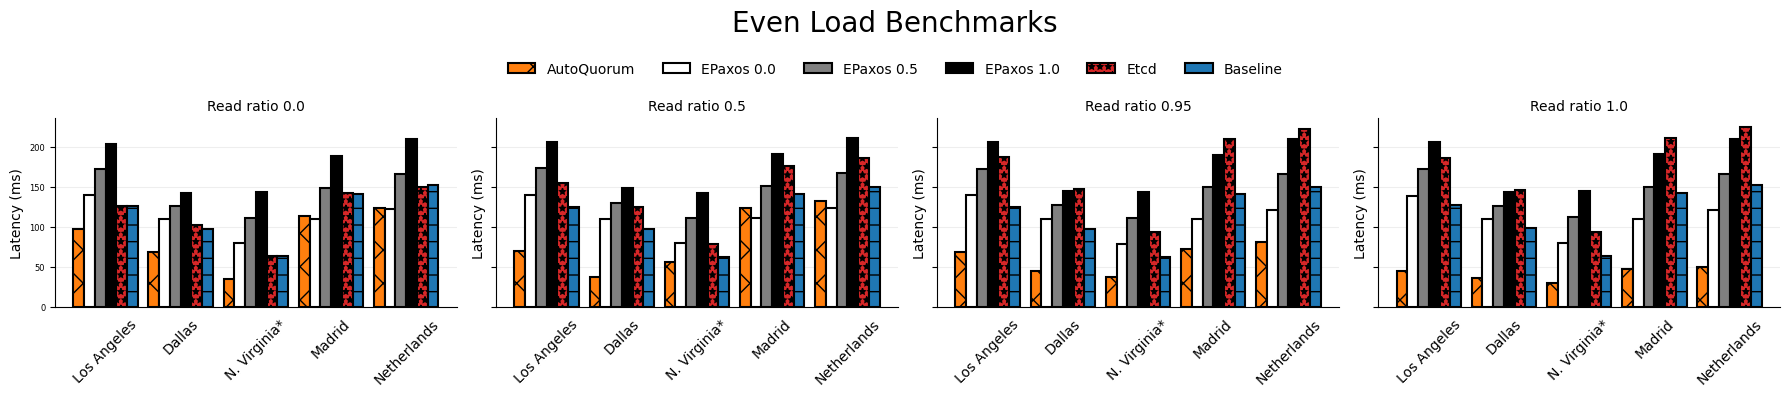

In [24]:
from graphs.even_load import graph_even_load
graph_even_load()

In [28]:
from graphs.even_load import even_load_data
for ratio in [0.0, 0.5, 0.95, 1.0]:
    exp_data = even_load_data(f"read-ratio-{ratio}/AutoQuorum")
    exp_data.show_reconfigurations()

,curr_strat_latency,opt_strat_latency,curr_strat,opt_strat
timestamp,,,,


,curr_strat_latency,opt_strat_latency,curr_strat,opt_strat
timestamp,,,,
2025-03-13 12:06:48.264,102.103834,81.698235,"{'leader': 3, 'read_quorum_size': 4, 'write_quorum_size': 2, 'read_strategies': ['ReadAsWrite', 'ReadAsWrite', 'ReadAsWrite', 'ReadAsWrite', 'ReadAsWrite']}","{'leader': 2, 'read_quorum_size': 3, 'write_quorum_size': 3, 'read_strategies': ['ReadAsWrite', 'QuorumRead', 'ReadAsWrite', 'BallotRead', 'BallotRead']}"


,curr_strat_latency,opt_strat_latency,curr_strat,opt_strat
timestamp,,,,
2025-03-13 12:07:34.667,85.128239,61.545769,"{'leader': 3, 'read_quorum_size': 4, 'write_quorum_size': 2, 'read_strategies': ['ReadAsWrite', 'ReadAsWrite', 'ReadAsWrite', 'ReadAsWrite', 'ReadAsWrite']}","{'leader': 3, 'read_quorum_size': 2, 'write_quorum_size': 4, 'read_strategies': ['BallotRead', 'BallotRead', 'BallotRead', 'QuorumRead', 'BallotRead']}"


,curr_strat_latency,opt_strat_latency,curr_strat,opt_strat
timestamp,,,,
2025-03-13 12:08:19.083,93.342154,61.572335,"{'leader': 3, 'read_quorum_size': 4, 'write_quorum_size': 2, 'read_strategies': ['ReadAsWrite', 'ReadAsWrite', 'ReadAsWrite', 'ReadAsWrite', 'ReadAsWrite']}","{'leader': 2, 'read_quorum_size': 2, 'write_quorum_size': 4, 'read_strategies': ['BallotRead', 'BallotRead', 'BallotRead', 'QuorumRead', 'BallotRead']}"
2025-03-13 12:08:21.097,70.070600,56.101985,"{'leader': 2, 'read_quorum_size': 2, 'write_quorum_size': 4, 'read_strategies': ['BallotRead', 'BallotRead', 'BallotRead', 'QuorumRead', 'BallotRead']}","{'leader': 3, 'read_quorum_size': 2, 'write_quorum_size': 4, 'read_strategies': ['BallotRead', 'BallotRead', 'BallotRead', 'BallotRead', 'BallotRead']}"
